# Bikeshare rides (Summer 2018)
This notebook analyzes bikeshare data for NYC citibikes. 

Here we get some of the bike data (Jun - Aug of 2018) as a sample set and perform some basic exploratory analysis and plot-making

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm



from mpl_toolkits.basemap import Basemap


In [2]:
summer_df_list = []

for el in ['06','07','08']:
    summer_df_list.append(pd.read_csv('../data/NYC/2018/2018{}-citibike-tripdata/2018{}-citibike-tripdata.csv'.format(el,el)))

#df = pd.read_csv('./data/NYC/2018/201806-citibike-tripdata/201806-citibike-tripdata.csv')
summer_df_list[0].head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1


In [3]:
#Concat them all together into one dataframe
summer_df = pd.concat(summer_df_list,ignore_index=True)
summer_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72.0,W 52 St & 11 Ave,40.767272,-73.993929,173.0,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72.0,W 52 St & 11 Ave,40.767272,-73.993929,477.0,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72.0,W 52 St & 11 Ave,40.767272,-73.993929,457.0,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72.0,W 52 St & 11 Ave,40.767272,-73.993929,379.0,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72.0,W 52 St & 11 Ave,40.767272,-73.993929,459.0,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1


In [4]:
summer_df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,5.843905e+06,5.842517e+06,5.843905e+06,5.843905e+06,5.842517e+06,5.843905e+06,5.843905e+06,5.843905e+06,5.843905e+06,5.843905e+06
mean,1.099096e+03,1.615055e+03,4.073714e+01,-7.398253e+01,1.608992e+03,4.073677e+01,-7.398269e+01,2.604607e+04,1.979251e+03,1.134752e+00
std,1.842150e+04,1.444277e+03,3.186483e-02,1.965180e-02,1.443901e+03,3.177415e-02,1.973521e-02,5.976156e+03,1.174067e+01,5.727464e-01
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.800000e+02,3.820000e+02,4.071723e+01,-7.399596e+01,3.800000e+02,4.071689e+01,-7.399601e+01,2.012300e+04,1.969000e+03,1.000000e+00
50%,6.520000e+02,5.080000e+02,4.073726e+01,-7.398565e+01,5.070000e+02,4.073705e+01,-7.398602e+01,2.765800e+04,1.982000e+03,1.000000e+00
75%,1.149000e+03,3.255000e+03,4.075898e+01,-7.397152e+01,3.255000e+03,4.075757e+01,-7.397188e+01,3.111500e+04,1.989000e+03,1.000000e+00
max,7.571338e+06,3.705000e+03,4.550636e+01,-7.356891e+01,3.705000e+03,4.550636e+01,-7.356891e+01,3.483900e+04,2.002000e+03,2.000000e+00


In [5]:
#Number of weekend days and weekday days for Jan - March 2018
num_WD = 31+31+30-26
num_WE = 26 #Note I'm not subtracting holidays here, maybe later...

The next few cells use the functions in `bike_share_functions.py` to clean the bike data and assemble an independent station dataframe and export pickled versions of the various dataframes.

In particular, `bike_clean_df` does the f non-subscribers, 


In [7]:
import sys
sys.path.append('../')

from bike_share_functions import bike_clean_df

subs_df = bike_clean_df(summer_df)

In [8]:
from bike_share_functions import get_stations_info

stations_info_df = get_stations_info(subs_df)
print(len(stations_info_df)) # get the number of stations
stations_info_df.head()


802


,lat,lon,station name
72,40.767272,-73.993929,W 52 St & 11 Ave
79,40.719116,-74.006667,Franklin St & W Broadway
82,40.711174,-74.000165,St James Pl & Pearl St
83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl
119,40.696089,-73.978034,Park Ave & St Edwards St


In [9]:
from bike_share_functions import get_trip_info

subs_trips_df = get_trip_info(subs_df)

subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
0,569,2018-06-01 01:57:20.514,2018-06-01 02:06:50.088,72,173,21481,Subscriber,1999,1,4,4,1,2,19,Late Night,"(72, 173)"
1,480,2018-06-01 02:02:42.398,2018-06-01 02:10:43.354,72,477,19123,Subscriber,1988,1,4,4,2,2,30,Late Night,"(72, 477)"
2,692,2018-06-01 02:04:23.624,2018-06-01 02:15:55.747,72,457,26983,Subscriber,1986,1,4,4,2,2,32,Late Night,"(72, 457)"
3,664,2018-06-01 03:00:55.461,2018-06-01 03:11:59.906,72,379,26742,Subscriber,1973,1,4,4,3,3,45,Late Night,"(72, 379)"
4,818,2018-06-01 06:04:54.427,2018-06-01 06:18:32.617,72,459,26386,Subscriber,1984,1,4,4,6,6,34,Commuter,"(72, 459)"


In [8]:
#Export the results as pickled dateframes for use in other analyses 
subs_df.to_pickle('../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df.to_pickle('../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df.to_pickle('../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')

In [10]:
#Separate out the weekday and weekend trips
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [11]:
summer_df[['tripduration','birth year']].describe()

,tripduration,birth year
count,5.842517e+06,5.842517e+06
mean,1.098695e+03,1.979249e+03
std,1.842145e+04,1.174024e+01
min,6.100000e+01,1.885000e+03
25%,3.800000e+02,1.969000e+03
50%,6.520000e+02,1.982000e+03
75%,1.149000e+03,1.989000e+03
max,7.571338e+06,2.002000e+03


In [12]:
weekday_subs_trips_df[['tripduration','age']].describe()

,tripduration,age
count,3.935189e+06,3.935189e+06
mean,7.517541e+02,3.833958e+01
std,5.717604e+02,1.184741e+01
min,6.100000e+01,1.600000e+01
25%,3.530000e+02,2.900000e+01
50%,5.820000e+02,3.600000e+01
75%,9.800000e+02,4.700000e+01
max,7.199000e+03,1.330000e+02


In [13]:
total_weekday = weekday_subs_trips_df[['tripduration','age']].describe().loc['count']['tripduration']
total_weekend = weekend_subs_trips_df[['tripduration','age']].describe().loc['count']['tripduration']

total_weekday+total_weekend

5021235.0

The following are just simple plots of various aspects of the data

Text(0.5, 1.0, 'Total Trips per Hour (weekdays)')

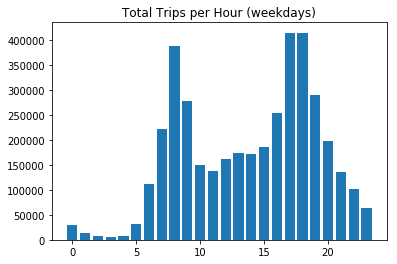

In [14]:
#Total trips (= num pickups) by hour (weekday)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)
ax.set_title('Total Trips per Hour (weekdays)')


Text(0.5, 1.0, 'Total Trips per Hour (weekends)')

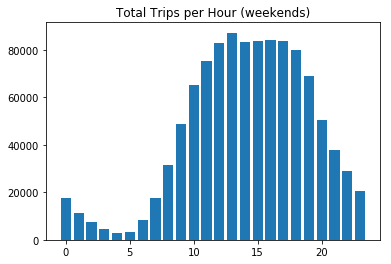

In [15]:
#Total trips by hour (weekend)
fig = plt.figure()
ax = fig.gca()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['starttime'].count()

ax.bar(total_rides_by_hour.index,total_rides_by_hour)
ax.set_title('Total Trips per Hour (weekends)')

Text(0.5, 1.0, 'Pickups per hour for top (hourly) weekday station \n (station #519: Pershing Square North)')

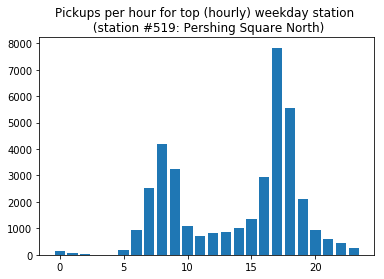

In [17]:
plt.figure() 
ax = plt.gca()

total_rides_by_hr_st = weekday_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
total_rides_by_hr_st = total_rides_by_hr_st.rename('total_trips') 

max_pu_st = total_rides_by_hr_st.idxmax()[1]

top_pu_station = total_rides_by_hr_st.loc[:,max_pu_st]


ax.bar(top_pu_station.index,top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) station (weekday)')
ax.set_title('Pickups per hour for top (hourly) weekday station \n (station #{}: {})'.format(max_pu_st,stations_info_df.loc[max_pu_st]['station name']))


#plt.bar(top_do_station.index,top_do_station)

Text(0.5, 1.0, 'Pickups per hour for top (hourly) station (weekend) \n (station #497: E 17 St & Broadway)')

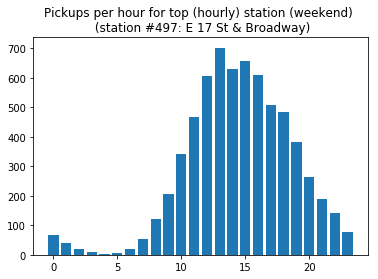

In [18]:
#Hourly pickups for station with max trips in any given hour
plt.figure() 
ax = plt.gca()

total_rides_by_hr_st = weekend_subs_trips_df.groupby(['pickup_hour','start station id'])['tripduration'].count()
total_rides_by_hr_st = total_rides_by_hr_st.rename('total_trips') 

max_pu_st = total_rides_by_hr_st.idxmax()[1]

top_pu_station = total_rides_by_hr_st.loc[:,max_pu_st]


ax.bar(top_pu_station.index,top_pu_station)
#ax.set_title('Pickups per hour for top (hourly) weekend station')
ax.set_title('Pickups per hour for top (hourly) station (weekend) \n (station #{}: {})'.format(max_pu_st,stations_info_df.loc[max_pu_st]['station name']))

#plt.bar(top_do_station.index,top_do_station)

Text(0.5, 1.0, 'Average trip duration by hour (weekday)')

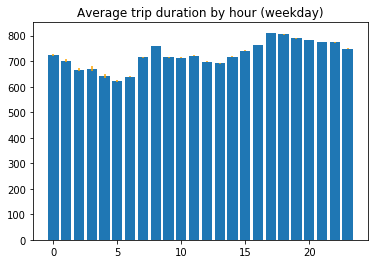

In [19]:
fig = plt.figure()
ax = fig.gca()


avg_duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
yerror = weekday_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(total_rides_by_hour)**(1/2)

ax.bar(avg_duration_by_hour.index,avg_duration_by_hour, yerr=yerror,ecolor = 'orange')
ax.set_title('Average trip duration by hour (weekday)')

Text(0.5, 1.0, 'Average trip duration by hour (weekend)')

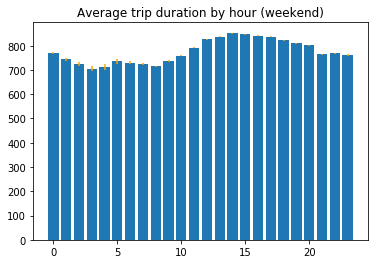

In [20]:
fig = plt.figure()
ax = fig.gca()

avg_duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].mean()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].count()
yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/(total_rides_by_hour)**(1/2)
#yerror = weekend_subs_trips_df.groupby('pickup_hour')['tripduration'].std()/avg_duration_by_hour

ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average trip duration by hour (weekend)')

Text(0.5, 1.0, 'Average age by hour (weekday)')

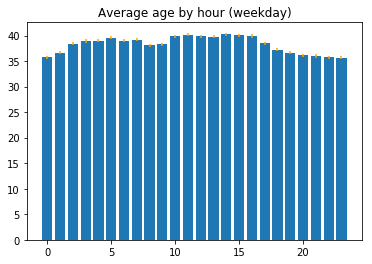

In [21]:
fig = plt.figure()
ax = fig.gca()

avg_age_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].mean()

total_rides_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['age'].count()
#yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/(total_rides_by_hour)**(1/2)
yerror = weekday_subs_trips_df.groupby('pickup_hour')['age'].std()/avg_age_by_hour #Relative standard deviation instead of std dev of mean

ax.bar(avg_age_by_hour.index,avg_age_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average age by hour (weekday)')

Text(0.5, 1.0, 'Average age by hour (weekend)')

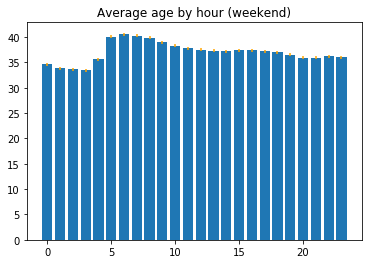

In [22]:
fig = plt.figure()
ax = fig.gca()

avg_age_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].mean()

total_rides_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['age'].count()
#yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/(total_rides_by_hour)**(1/2)
yerror = weekend_subs_trips_df.groupby('pickup_hour')['age'].std()/avg_age_by_hour

ax.bar(avg_age_by_hour.index,avg_age_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Average age by hour (weekend)')

Text(0.5, 1.0, 'Trip duration histogram (weekday)')

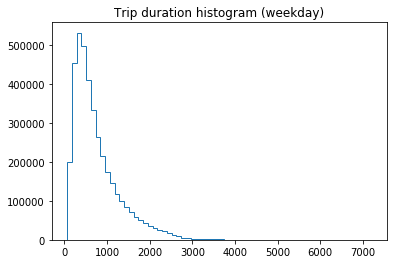

In [23]:
fig = plt.figure()
ax = fig.gca()


weekday_subs_trips_df['tripduration'].hist(bins=64,histtype='step')
ax.grid(False)

ax.set_title('Trip duration histogram (weekday)')

Text(0.5, 1.0, 'Trip duration histogram (weekend)')

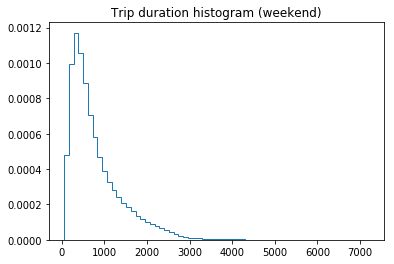

In [24]:
fig = plt.figure()
ax = fig.gca()


weekend_subs_trips_df['tripduration'].hist(bins=64,histtype='step',density=True)

ax.grid(False)

ax.set_title('Trip duration histogram (weekend)')

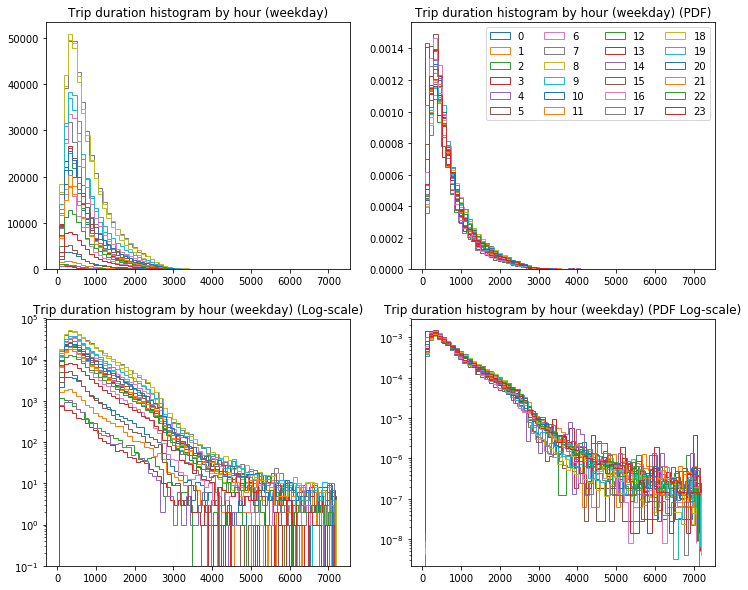

In [54]:
fig, ax = plt.subplots(2,2,figsize=(12,10))



duration_by_hour = weekday_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekday)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration histogram by hour (weekday) (PDF)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekday) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration histogram by hour (weekday) (PDF Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

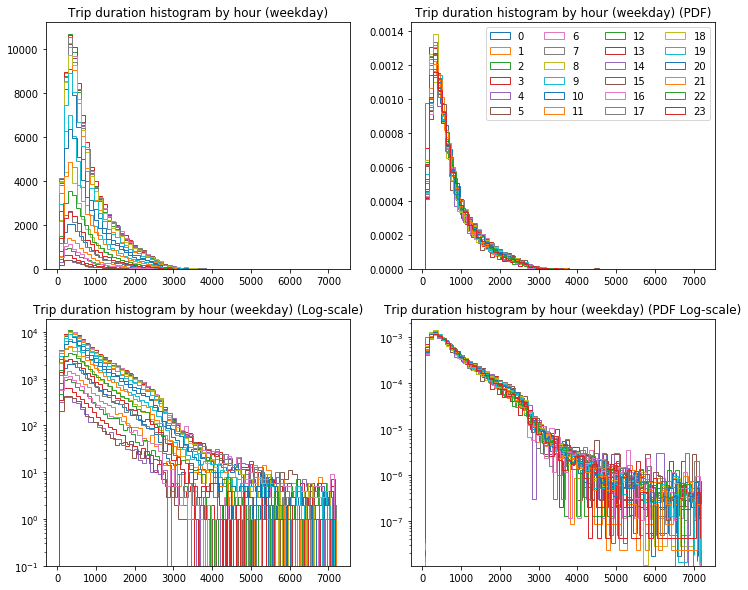

In [55]:
fig, ax = plt.subplots(2,2,figsize=(12,10))



duration_by_hour = weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

plt.sca(ax[0,0])
duration_by_hour.hist(bins=64,histtype ='step')

plt.sca(ax[0,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True)

plt.sca(ax[1,0])
duration_by_hour.hist(bins=64,histtype ='step',log=True)

plt.sca(ax[1,1])
duration_by_hour.hist(bins=64,histtype ='step',density=True,log=True)

ax[0,0].set_title('Trip duration histogram by hour (weekday)')
ax[0,0].grid(False)


ax[0,1].set_title('Trip duration histogram by hour (weekday) (PDF)')
ax[0,1].grid(False)

ax[1,0].set_title('Trip duration histogram by hour (weekday) (Log-scale)')
ax[1,0].grid(False)


ax[1,1].set_title('Trip duration histogram by hour (weekday) (PDF Log-scale)')
ax[1,1].grid(False)

ax[0,1].legend(labels = list(range(24)),ncol=4)

Text(0.5, 1.0, 'Age histogram (weekday)')

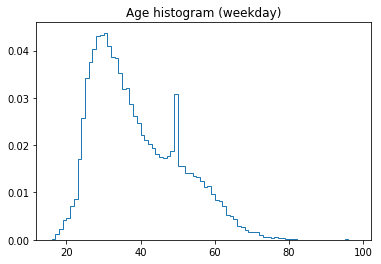

In [27]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekday_subs_trips_df[weekday_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step',density=True)
#ax.hist(duration_by_hour)

ax.grid(False)
#ax.bar(avg_duration_by_hour.index,avg_duration_by_hour,yerr=yerror, ecolor='orange')
ax.set_title('Age histogram (weekday)')
#ax.legend(labels = list(range(24)),ncol=4)

Text(0.5, 1.0, 'Age histogram (weekend)')

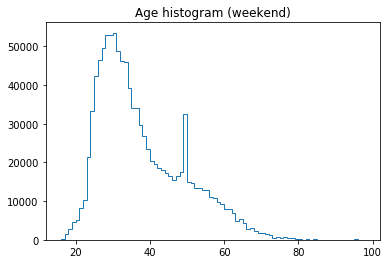

In [28]:
fig = plt.figure()
ax = fig.gca()


ages_series  = weekend_subs_trips_df[weekend_subs_trips_df['age'] < 100]['age']
#duration_by_hour = short_weekend_subs_trips_df.groupby('pickup_hour')['tripduration']

ages_series.hist(bins=list([n for n in range(ages_series.min(),ages_series.max())]),histtype='step')
#ax.hist(duration_by_hour)

ax.grid(False)

ax.set_title('Age histogram (weekend)')

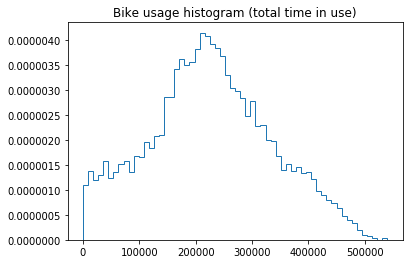

In [31]:
fig = plt.figure()
ax = fig.gca()

total_duration_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].sum()


total_duration_by_bikeid.hist(bins=60,histtype='step',density=True)
ax.grid(False)

ax.set_title('Bike usage histogram (total time in use)');

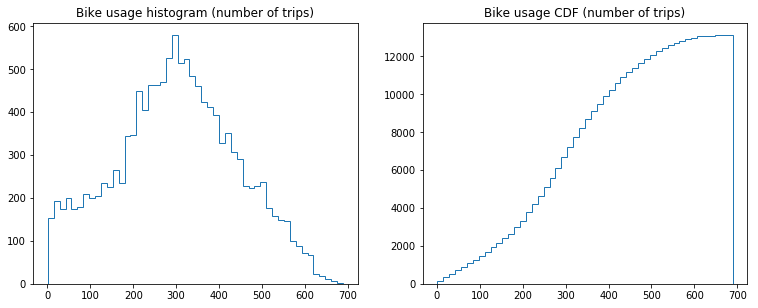

In [32]:
fig = plt.subplots(1,2,figsize=(12.8,4.8))
#ax = fig.gca()

total_trips_by_bikeid = weekday_subs_trips_df.groupby('bikeid')['tripduration'].count()

plt.subplot(121)
total_trips_by_bikeid.hist(bins=50,histtype='step')#,density=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage histogram (number of trips)')

plt.subplot(122)
total_trips_by_bikeid.hist(bins=50,histtype='step',cumulative=True)
plt.grid(False)
ax=plt.gca()
ax.set_title('Bike usage CDF (number of trips)')

plt.show()



#ax.set_title('Bike usage histogram (total trips)')
#total_trips_by_bikeid.sort_values(ascending=False).head()

In [33]:
#fig = plt.figure()
#ax = fig.gca()

total_duration_by_bikeid.nlargest(10)

#ax.bar(total_duration_by_bikeid.index,total_duration_by_bikeid)
#ax.set_title('Total use by bike')

bikeid
30868    539979
32427    539781
33522    536451
33162    532381
31217    520628
33094    518004
30512    517413
30996    513769
29982    511402
30502    510931
Name: tripduration, dtype: int64

In [ ]:
#weekday_subs_trips_df.hist(column = 'tripduration', by=weekday_subs_trips_df.pickup_hour, bins = 144,density=True,histtype='step')